In [2]:
# load the data from the last time

import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
from matplotlib import cm
import plotly.graph_objects as go
import numpy as np



In [3]:
data = pd.read_csv('FS - Simple DOE - Sheet1.csv')#, sep='\t')
data.columns = ['Unnamed: 0', 'FS Load From BQ', 'n_features', 'n_predictions',
       'n_workers', 'total_seconds', 'response_ms', 'per_prediction']

In [4]:
data.head()

,Unnamed: 0,FS Load From BQ,n_features,n_predictions,n_workers,total_seconds,response_ms,per_prediction
0,0,415.242187,56,7,8,0.245202,245.201588,35.028798
1,1,415.242187,56,7,8,0.176273,176.272631,25.181804
2,2,415.242187,56,7,8,0.150885,150.885105,21.555015
3,3,415.242187,56,7,8,0.191720,191.720247,27.388607
4,4,415.242187,56,7,8,0.199270,199.270248,28.467178


In [5]:
#prep the data

data['ms_per_entity'] = data['total_seconds'] / data['n_predictions'] * 1000
data['total_ms'] = data['total_seconds'] * 1000
data.head()

,Unnamed: 0,FS Load From BQ,n_features,n_predictions,n_workers,total_seconds,response_ms,per_prediction,ms_per_entity,total_ms
0,0,415.242187,56,7,8,0.245202,245.201588,35.028798,35.028798,245.201588
1,1,415.242187,56,7,8,0.176273,176.272631,25.181804,25.181804,176.272631
2,2,415.242187,56,7,8,0.150885,150.885105,21.555015,21.555015,150.885105
3,3,415.242187,56,7,8,0.191720,191.720247,27.388607,27.388607,191.720247
4,4,415.242187,56,7,8,0.199270,199.270248,28.467178,28.467178,199.270248


[(0.0, 100.0)]

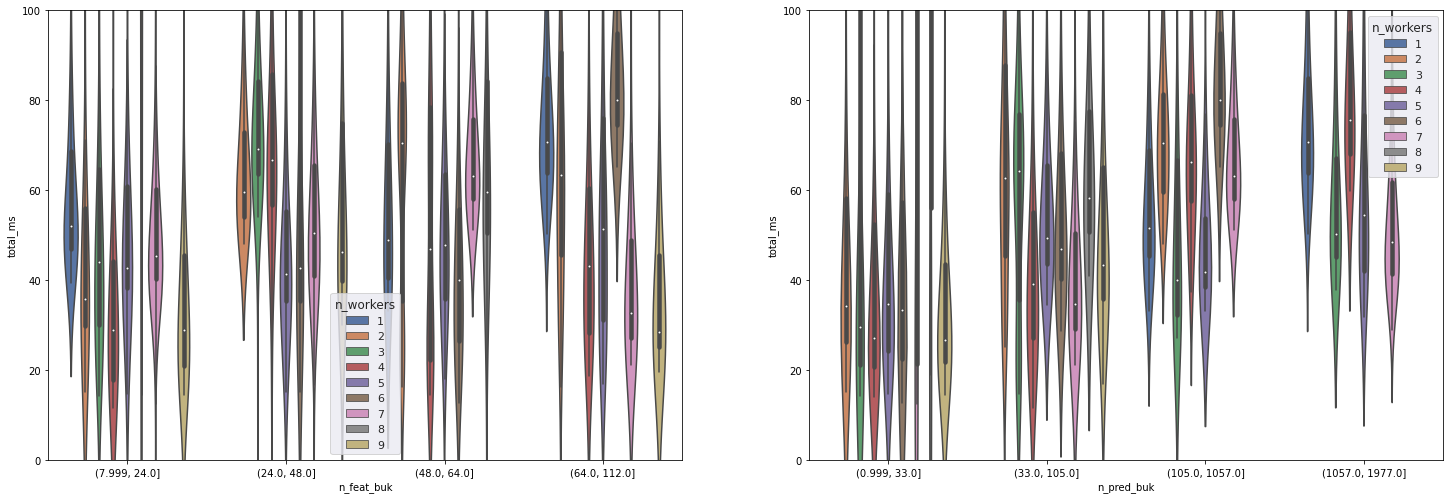

In [6]:
# categorical chart
#create quantiles for n_features and n
import matplotlib.pyplot as plt
import seaborn as sns


a4_dims = (25, 8.27)
fig, ax = plt.subplots(1, 2, figsize=a4_dims)
#fig2, ax2 = plt.subplots(figsize=a4_dims)
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['n_feat_buk'] = pd.qcut(data['n_features'], 4)
data['n_pred_buk'] = pd.qcut(data['n_predictions'], 4)
#remove observations with less than 50 measurments
#data['point'] = str(data['n_workers']) + "_" + str(data['n_features']) + "_" + str(data['n_predictions'])
                                                                                  
data_de_noised = data[data.groupby('point').point.transform('count')>50].copy() 
violin_plot = sns.violinplot(x="n_feat_buk", y="total_ms", hue="n_workers",
               data=data, kind="violin", ax=ax[0])
violin_plot.set(ylim=(0, 100))

violin_plot2 = sns.violinplot(x="n_pred_buk", y="total_ms", hue="n_workers",
               data=data, kind="violin", ax=ax[1])
violin_plot2.set(ylim=(0, 100))


In [7]:
# ols model

model = ols("""total_ms ~ n_features + n_predictions + n_workers + 
            n_features*n_predictions + n_features*n_workers + 
            n_predictions*n_workers + n_features*n_workers*n_predictions + I(np.log(n_features)) + I(np.log(n_workers)) + I(np.log(n_predictions))
            """, data=data).fit()

table = sm.stats.anova_lm(model, typ=3)
table


,sum_sq,df,F,PR(>F)
Intercept,1.750569e+05,1.0,66.812218,3.138175e-16
n_features,3.135095e+04,1.0,11.965406,5.429495e-04
n_predictions,1.225486e+04,1.0,4.677191,3.057591e-02
n_workers,5.769889e+02,1.0,0.220214,6.388816e-01
n_features:n_predictions,3.380926e+02,1.0,0.129036,7.194365e-01
n_features:n_workers,5.676276e+04,1.0,21.664080,3.266175e-06
n_predictions:n_workers,6.659394e+04,1.0,25.416251,4.654949e-07
n_features:n_workers:n_predictions,4.955186e+04,1.0,18.911968,1.374760e-05
I(np.log(n_features)),4.271507e+03,1.0,1.630264,2.016794e-01
I(np.log(n_workers)),9.109189e+03,1.0,3.476614,6.225463e-02


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_ms   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     54.70
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          8.50e-110
Time:                        15:29:03   Log-Likelihood:            -1.2395e+05
No. Observations:               23150   AIC:                         2.479e+05
Df Residuals:                   23139   BIC:                         2.480e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             43.3378      5.302      8.174      0.000      32.946      53.730
n_features                             0.1842      0.053      3.459      0.001       0.080       0.289
n_predictions                          0.0072      0.003      2.163      0.031       0.001       0.014
n_workers                              0.3126      0.666      0.469      0.639      -0.993       1.618
n_features:n_predictions           -1.721e-05   4.79e-05     -0.359      0.719      -0.000    7.67e-05
n_features:n_workers                  -0.0376      0.008     -4.654      0.000      -0.053      -0.022
n_predictions:n_workers               -0.0028      0.001     -5.041      0.000      -0.004      -0.002
n_features:n_workers:n_predictions  4.382e-05   1.01e-05      4.349      0.000    2.41e-05    6.36e-05
I(np.log(n_features))                  2.2016      1.724      1.277      0.202      -1.178       5.581
I(np.log(n_workers))                   3.7678      2.021      1.865      0.062      -0.193       7.729
I(np.log(n_predictions))               1.7186      0.343      5.018      0.000       1.047       2.390
==============================================================================
Omnibus:                    17888.450   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1478727.452
Skew:                           3.102   Prob(JB):                         0.00
Kurtosis:                      41.659   Cond. No.                     2.67e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
#create data aggregates for visualisation

def p90(g):
    return np.percentile(g, 90)

data_avg = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=np.average)
data_med = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=np.median)
data_p90 = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=p90)
data_avg = data_avg.reset_index()
data_med = data_med.reset_index()
data_p90 = data_p90.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


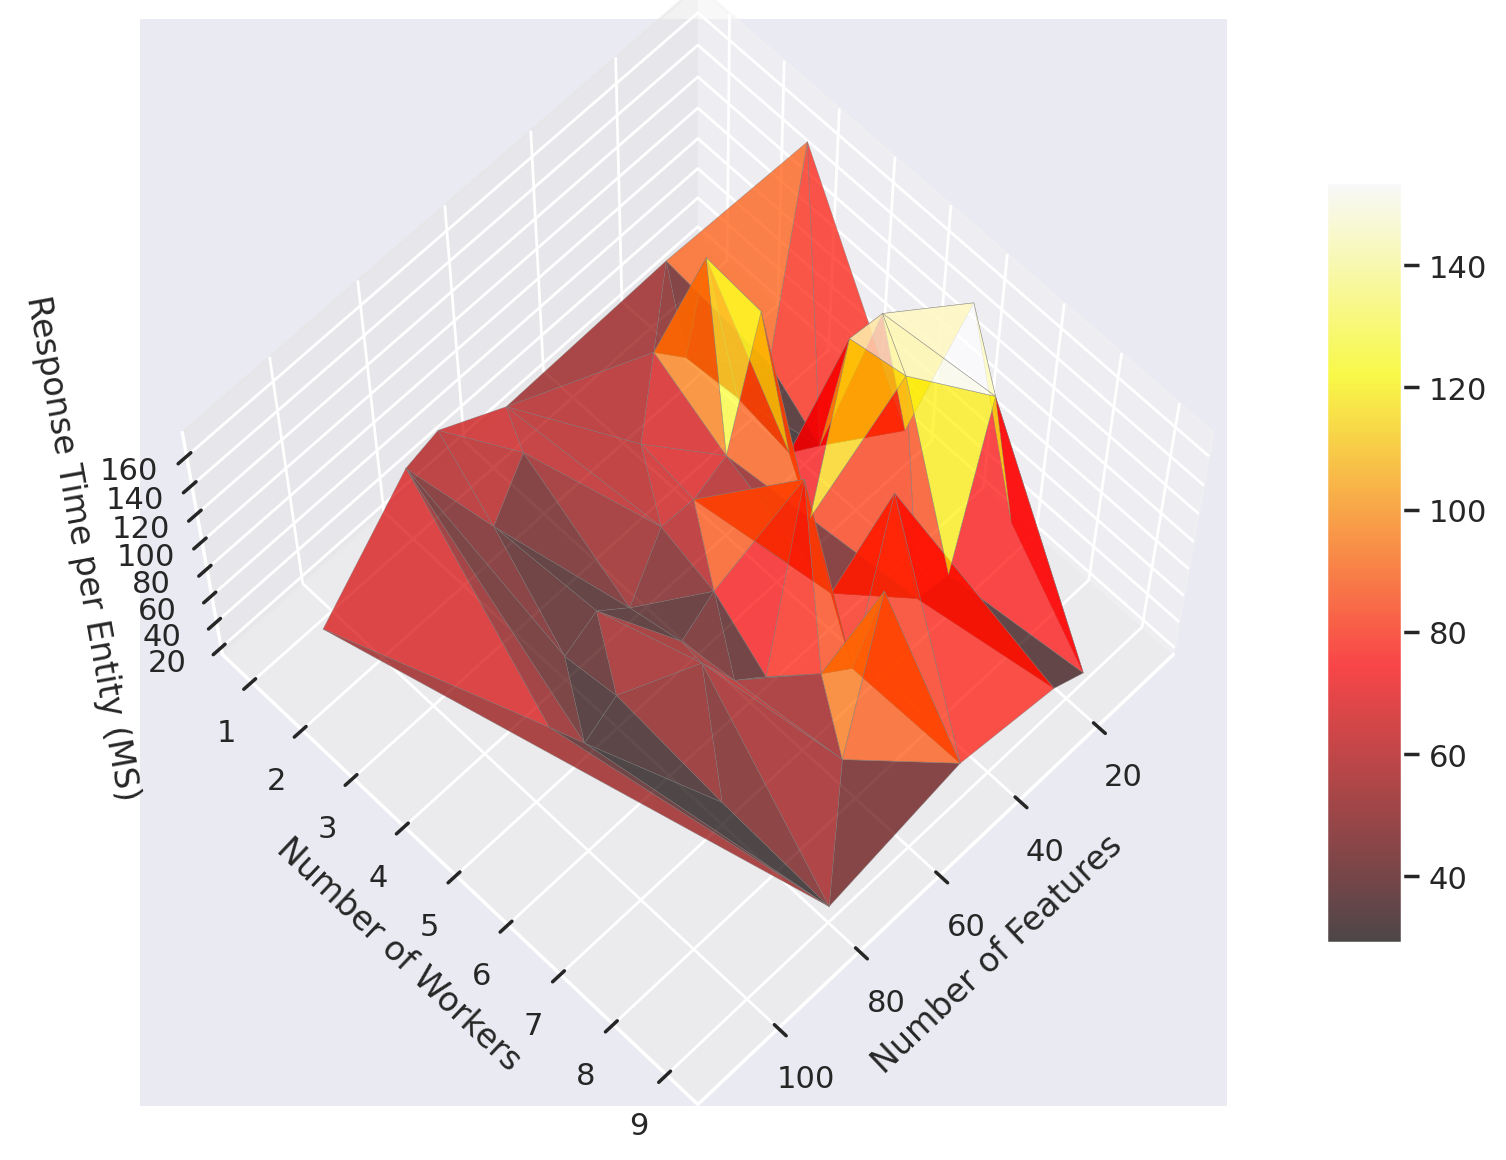

In [16]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
import plotly.figure_factory as ff
import plotly.graph_objects as go


light = (90, 20)
figsize=(16*.8,9*.8)
my_cmap = plt.get_cmap('hot')
 
# # Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')
data_med = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features'], aggfunc=np.median).reset_index()
trisurf = ax.plot_trisurf(data_med['n_features'], data_med['n_workers'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.7, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(65, 45)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  from ipykernel import kernelapp as app


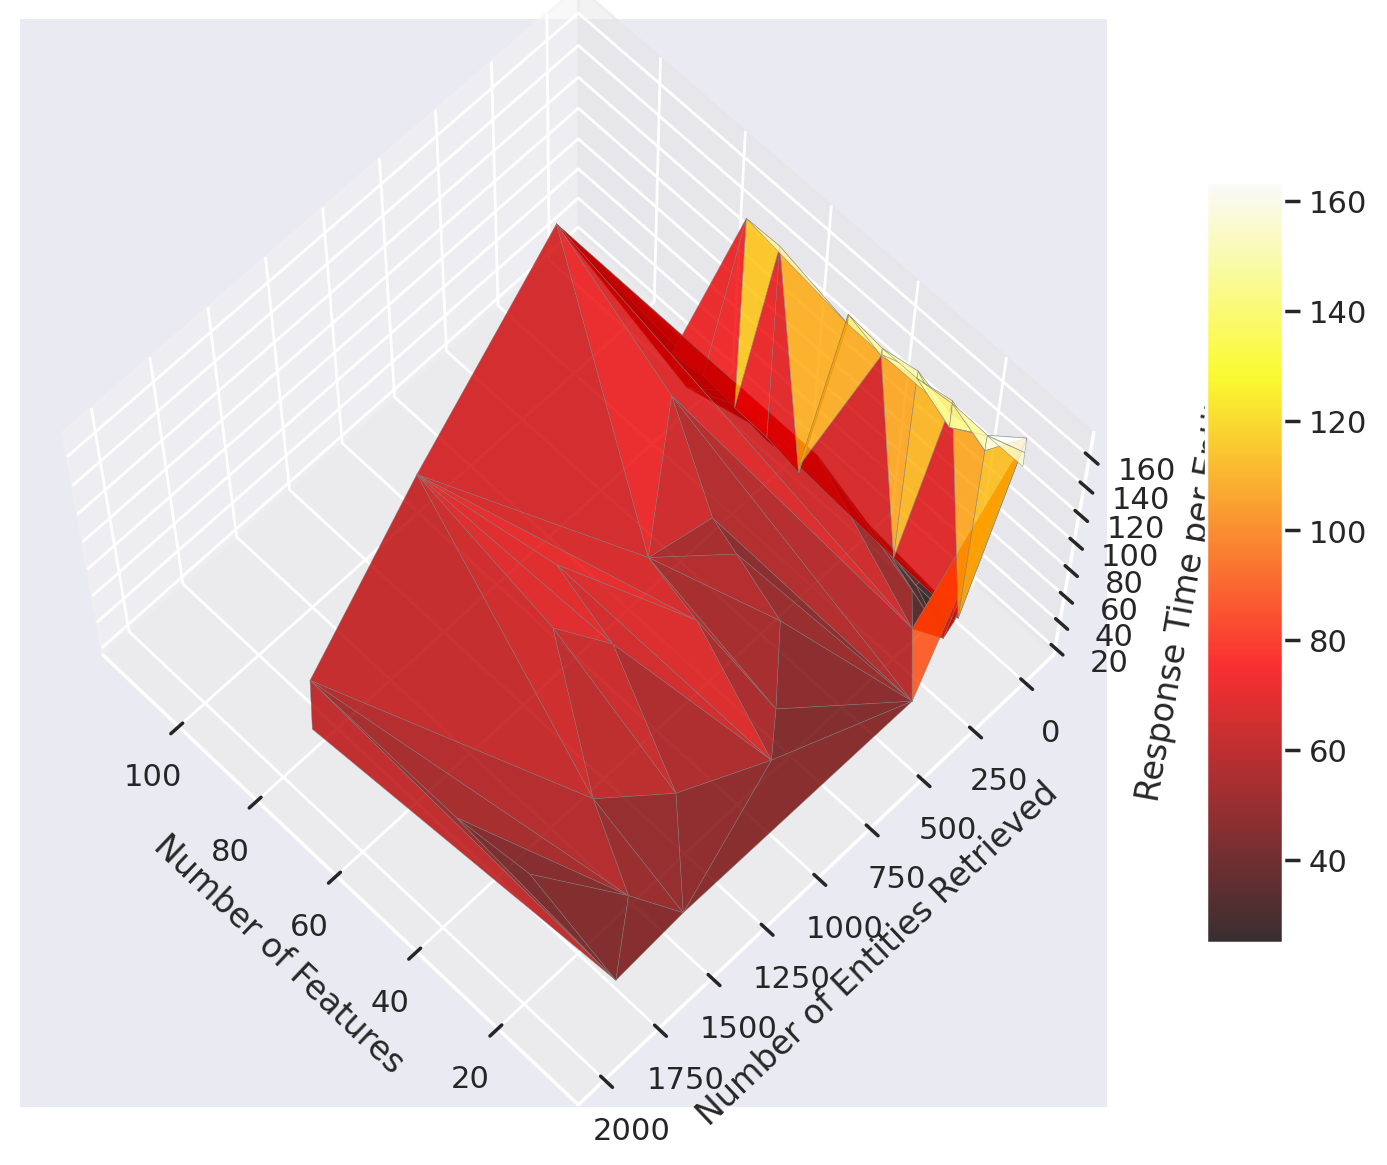

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 20)
figsize=(16*.8,9*.8)
my_cmap = plt.get_cmap('hot')
 
# Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')
data_med = pd.pivot_table(data, 'total_ms', index=['n_predictions','n_features'], aggfunc=np.median).reset_index()

trisurf = ax.plot_trisurf(data_med['n_features'], data_med['n_predictions'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.8, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(65, 135)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Entities Retrieved')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  from ipykernel import kernelapp as app


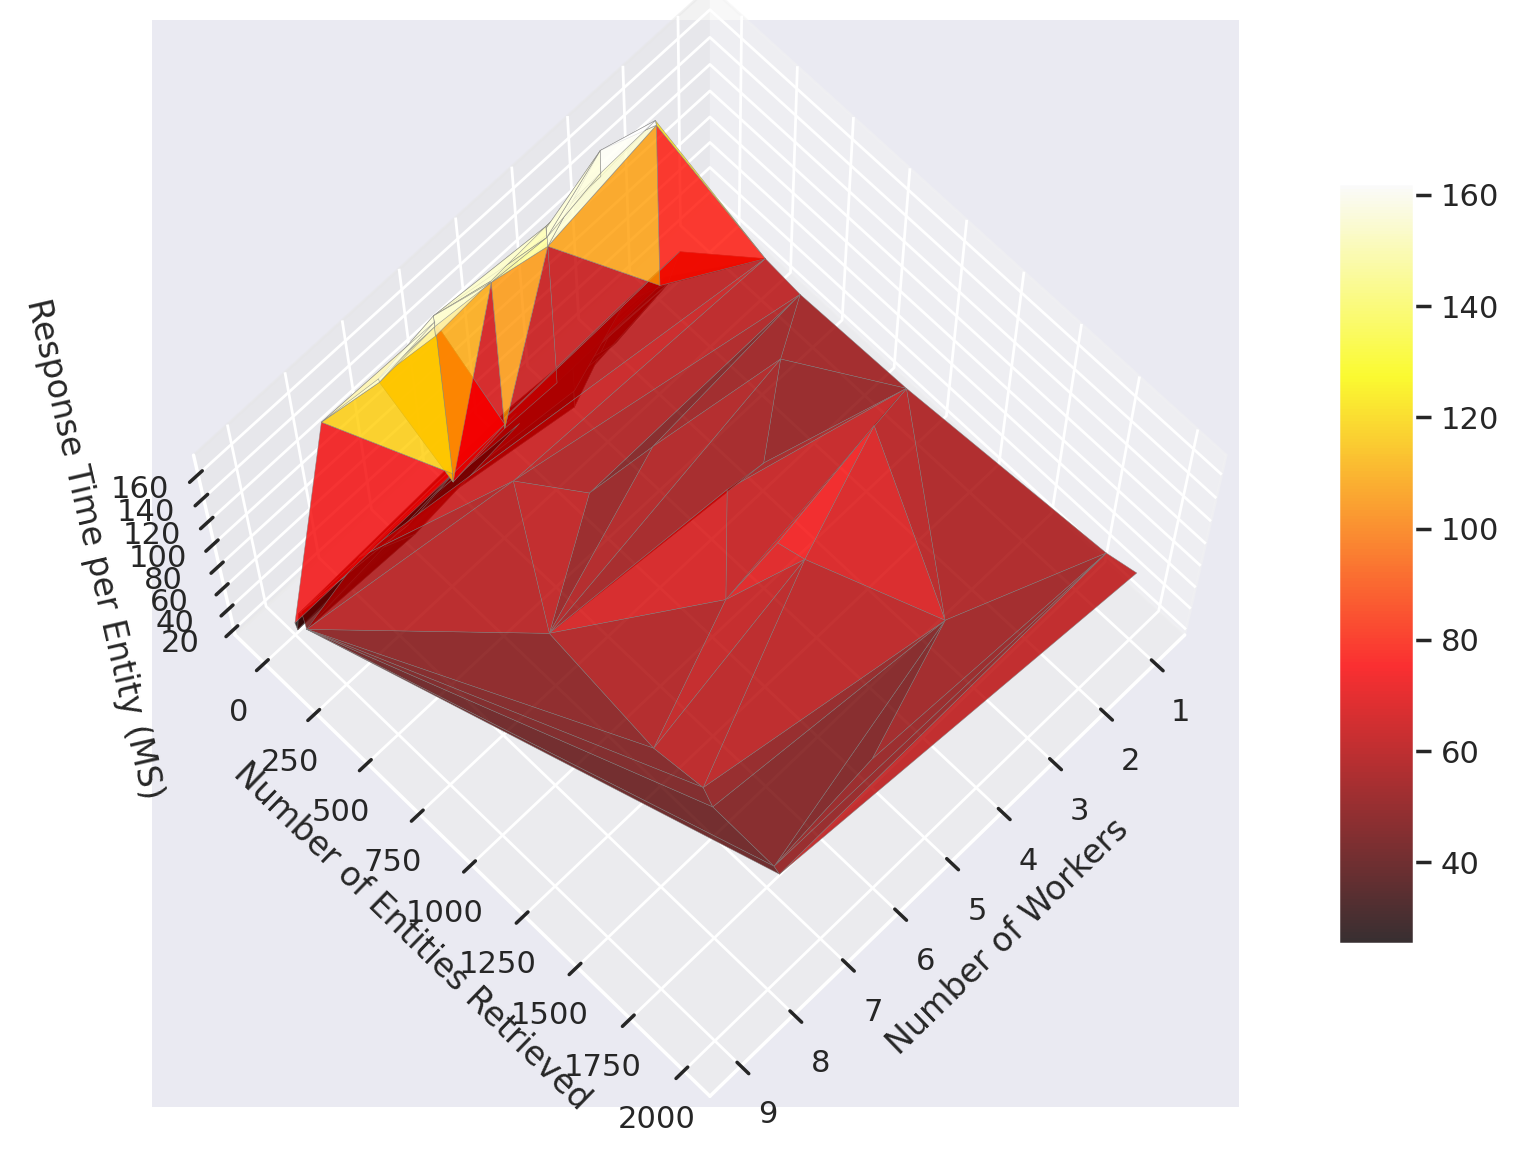

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 20)
figsize=(16*.8,9*.8)
my_cmap = plt.get_cmap('hot')
 
# Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')

data_med = pd.pivot_table(data, 'total_ms', index=['n_predictions','n_workers'], aggfunc=np.median).reset_index()
trisurf = ax.plot_trisurf(data_med['n_workers'], data_med['n_predictions'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.8, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(70, 45)
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Number of Entities Retrieved')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


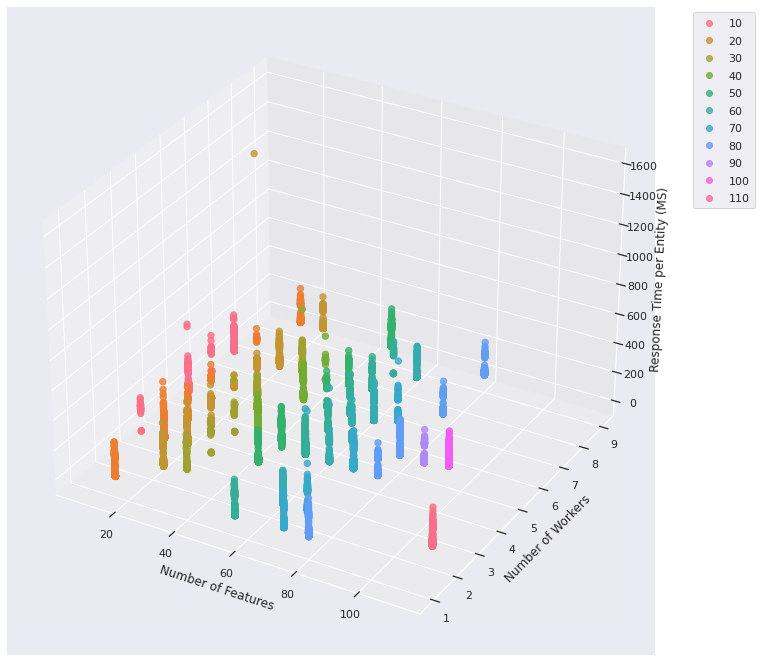

In [13]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

x = data['n_features']
y = data['n_workers']
z = data['total_ms']

# axes instance
fig = plt.figure(figsize=(16,9))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=.8)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Response Time per Entity (MS)')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

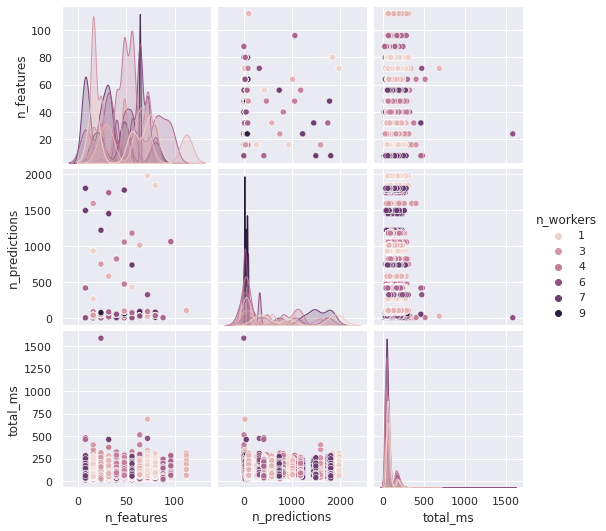

In [14]:
#Seaborn pair plot
df_3d = pd.DataFrame()
df_3d['n_features'] = x
df_3d['n_workers'] = y
df_3d['n_predictions'] = data['n_predictions']
df_3d['total_ms'] = z

sns.pairplot(df_3d, hue='n_workers' )